# Celdas preparatorias

`colab.research.google.com`

In [18]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
from sklearn.linear_model import LinearRegression
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# Statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ELCA_class1"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Obtención de los datos

Para estudiar el tema de la evaluación de modelos, vamos a obtener los datos de la última vez.

In [19]:
AIRLINE_PATH = "datasets/airline_fatalities"

In [20]:
if 'google.colab' in sys.modules:
        
    import tarfile

    DOWNLOAD_ROOT = "https://raw.githubusercontent.com/IAI-UNSAM/datasets/master/"
    AIRLINE_URL = DOWNLOAD_ROOT + "airline_fatalities/Data-Table\ 1.csv"

    def fetch_fatalities(AIRLINE_URL=AIRLINE_URL, airline_path=AIRLINE_PATH):
        os.makedirs(airline_path, exist_ok=True)
        !wget {AIRLINE_URL} -P {airline_path}

    # Corramos la función
    fetch_fatalities()

In [21]:
year, acc, deaths, rate = np.loadtxt(os.path.join(AIRLINE_PATH, 'Data-Table 1.csv'), delimiter=',', skiprows=2, unpack=True)

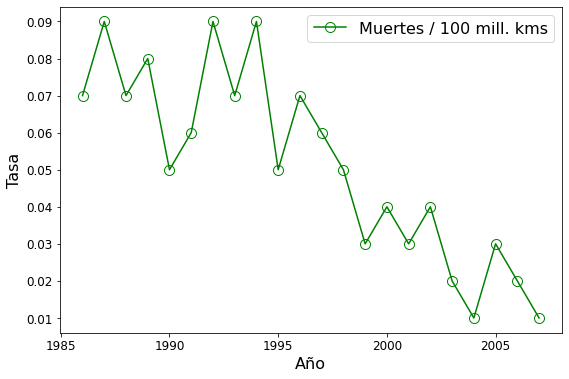

In [22]:
fig= plt.figure(figsize=(9, 6))

ax = fig.add_subplot(111)

l0, = ax.plot(year, rate, 'o-', mfc='None', ms=10, mew=1, color='g', label='Muertes / 100 mill. kms')

ax.set_xlabel('Año', fontsize=16)
ax.set_ylabel('Tasa', fontsize=16)

ax.legend(loc=0, fontsize=16)

In [23]:
rate.shape

(22,)

Vamos a ajustar un modelo lineal simple de la forma:

$$
y(\mathbf{x}, \boldsymbol{\omega}) = \omega_0 + \omega_1 \mathbf{x}\;\;.
$$

In [24]:
X = year.reshape(-1, 1)
print(X.shape)

(22, 1)


In [31]:
# Le damos forma a los datos para prepararlos para statsmodels
X = year.reshape(-1, 1) - year.mean()
t = rate.reshape(-1, 1)

# Add intercept term
X = sm.tools.add_constant(X)
print(X[:3])

# Ajusta el modelo
results = sm.OLS(t.flatten(), X).fit()

# Print results
print(results.summary())

# Compute the predictions
y = results.fittedvalues

[[  1.  -10.5]
 [  1.   -9.5]
 [  1.   -8.5]]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.731
Model:                            OLS   Adj. R-squared:                  0.717
Method:                 Least Squares   F-statistic:                     54.33
Date:                Thu, 02 Dec 2021   Prob (F-statistic):           4.04e-07
Time:                        14:44:14   Log-Likelihood:                 64.292
No. Observations:                  22   AIC:                            -124.6
Df Residuals:                      20   BIC:                            -122.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const 

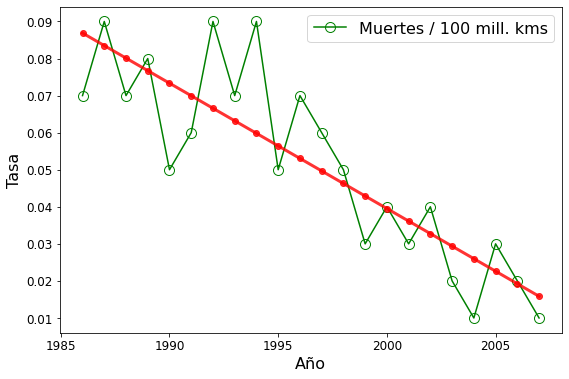

In [32]:
fig= plt.figure(figsize=(9, 6))

ax = fig.add_subplot(111)

l0, = ax.plot(year, rate, 'o-', mfc='None', ms=10, mew=1, color='g', label='Muertes / 100 mill. kms')
l1, = ax.plot(year, y, 'o-r', lw=3, alpha=0.8)
ax.set_xlabel('Año', fontsize=16)
ax.set_ylabel('Tasa', fontsize=16)

ax.legend(loc=0, fontsize=16)

También calculamos los residuos $\left\{r_i\right\}$, con $i = 1, \ldots, N$, definidos como la diferencia entre los valores medidos y la predicción del modelo:

$$
r_i = t_i - y(\mathbf{x}_i, \boldsymbol{\omega})\;\;.
$$

Una de las cosas para las que usamos los residuos fue para estimar la varianza de los términos de error $\epsilon_i$ [**Nota**: recordemos que suponemos $\epsilon_i \sim N(0, \sigma^2)$]:

$$
\widehat{\text{var}(\epsilon)} = \widehat{\sigma}^2 = \frac{1}{N-2}\sum_{i=1}^N r_i^2\;\;.
$$

Ese valor nos sirvió también para hacer inferencia sobre el parámetro $\omega_1$, y decidir si es significativamente diferente de cero, y para estimar el error que tendrán las predicciones que hagamos con el modelo.

Pero también podemos usar los residuos para evaluar la performance del modelo de muchas maneras diferentes. Esto se pude hacer para el modelo lineal simple, y es lo que vamos a ver ahora, pero es particularmente útil para el caso del modelo lineal múltiple, donde va a ser más difícil plotear directamente $y(\mathbf{x}, \mathbf{w})$. 

Pero primero tenemos que ver el concepto de *leverage*.

In [10]:
screg = np.sum((y - t.mean())**2)
scres = np.sum((t - y)**2)/(len(t)-2)

fratio = screg/scres
print('F-statistic = {:.2f} (es decir, ENORME)'.format(fratio))

import scipy.stats as st
my_f = st.f(dfn=1, dfd=len(t)-2)
print('La probabilidad de tener un valor de F-statistic al menos así de alto es {:.2e}'.format(1 - my_f.cdf(fratio)))

F-statistic = 0.38 (es decir, ENORME)
La probabilidad de tener un valor de F-statistic al menos así de alto es 5.43e-01


In [11]:
anova(t.flatten(), t.flatten().mean(), [y,], 1, [3,])

Model     	dof	diferencia          	dof	F-stat	p-value
-----     	---	----------          	---	------	-------
Base      	N-1
New_1     	N-3	New_1 - Base        	2 	25.8056	3.84e-06


In [12]:
t.shape

(22, 1)

# Evaluación de los modelos

## Leverage

El concepto de *leverage* o palanca es da gran utilidad para estudiar el funcionamiento del modelo y la influencia de los datos.

Se puede mostrar que el valor predicho de la variable $t$ para un valor del *feature* $x_i$ puede expresarse como una combinación lineal de *todos* los labels.

$$
y_i = \hat{\omega_0} + \hat{\omega_1} x_i = \sum_{k=1}^N h_{ik} t_k\;\;,
$$
donde $h_{ik}$ se define:

$$
h_{ik}: = \frac{1}{N} + \frac{\left(x_i - \bar{x}\right)\left(x_k - \bar{x}\right)}{S_{xx}}\;\;,
$$

con, recordemos, 
$$
\bar{x} = \frac{1}{N} \sum_{i=1}^N x_i
$$
y
$$
S_{xx} = \sum_{i=1}^N \left(x_i - \bar{x}\right)^2\;\;.
$$

Es decir, la predicción es una combinación lineal de los valores observados, pesada por el elemento $h_{ik}$ (de la matriz sombrero / hat). Ese valor $h_{ik}$ nos dice cuánto pesa cada medición $k$ en la predicción del valor $y_i$.

Let's compute this for our data, knowing that $\bar{x}=0$, because of the preprocessing (alright, I'll write the whole thing so you can use it in other cases!)

In [14]:
# this works in multi dimensions
if 'google.colab' in sys.modules:
        
    from scipy.linalg import cho_factor, cho_solve

    def hat_matrix(X, include_bias=True):
        """
        Compute hat matrix for design matrix X.

        :param np.array X: design matrix of dimensions (n x d), 
        where n is the number of observations and d is the number of
        features.
        :param bool include_bias: if True (default), then include a bias column, 
        in design matrix X (i.e. a column of ones - acts as an
        intercept term in a linear model).
        """
        if include_bias:
            X = np.hstack([np.ones([len(X), 1]), X])

        A = np.matmul(X.T, X)

        LL = cho_factor(A)
        return np.matmul(X, cho_solve(LL, X.T))
else: 
    from utils import hat_matrix
    
# Define HAT matrix, whose diagonal are the leverage values
h = hat_matrix(X)

Esta matriz nos dice cómo influye cada observación en la predicción de cualquier otra observación.

Podemos graficar la influencia que cada observación tiene sobre otras (tengan en cuenta que todo esto es independiente de $t$; solo tiene en cuenta los valores de la variable predictora).

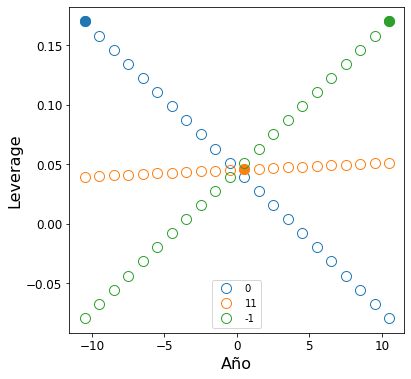

In [15]:
plt.figure(figsize=(6,6))

# Elijo que filas de la matriz voy a plotear.
indices_to_plot = [0, 11, -1]

for c,i in enumerate(indices_to_plot):
    plt.plot(X[:, 1], h[i], 'o', ms=10, mfc='None', label=i, color='C{}'.format(c))
    plt.plot(X[i, 1], h[i, i], 'o', ms=10, color='C{}'.format(c))
plt.xlabel('Año', fontsize=16)
plt.ylabel('Leverage', fontsize=16)
plt.legend(loc=0)

En particular, la diagonal de la matriz sombrero, que contiene el nivel de influencia de cada observación sobre su propia predicción, se conoce como *leverage* o palanca de esa observación.

Podemos graficarla en función de la variable predictora:

Text(0, 0.5, 'Leverage')

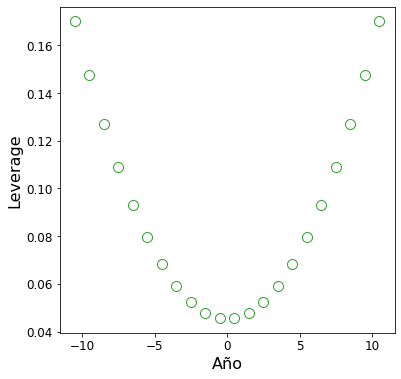

In [16]:
plt.figure(figsize=(6,6))

# Elijo que filas de la matriz voy a plotear.
plt.plot(X[:, 1], np.diag(h), 'o', ms=10, mfc='None', label=i, color='C{}'.format(c))
plt.xlabel('Año', fontsize=16)
plt.ylabel('Leverage', fontsize=16)

Como es razonable esperar a partir de la ecuación que define la matriz sombrero (y a partir de la intuición), las observaciones que se encuentran cerca se afectan más fuertemente. Es razonable pensar que se toma en cuenta la influencia local con mayor intensidad que la influencia general o global.

Esto será también el puntapié para entender métodos de *kernel*.

Antes de pasar al tema de residuos, mencionemos una propiedad más de los *leverage*:

$$
\sum_{i=1}^N h_{ii} = 2\;\;.
$$

Más en general, la suma de los *leverage* debe ser igual a la dimensión del vector de parámetros, $\boldsymbol{\omega}$, como puede verse de la definición de la matrix sombrero para el caso multidimensional (implementada en el modulo `utils`):

$$
H = \boldsymbol{\Phi}\;(\boldsymbol{\Phi}^T \boldsymbol{\Phi})^{-1} \boldsymbol{\Phi}^T\;\;,
$$

donde $\boldsymbol{\Phi}$ es la matrix de diseño que vimos la última clase, y tiene dimensiones $(N x D)$, donde $D$ es el número de funciones de base del modelo lineal.

## Residuos

### Residual plots

Ahora sí, volvamos a los residuos. 

Lo primero que uno puede hacer es graficarlos en función de la variable descriptiva, $x$.

/var/folders/ck/w8rvkm5x02jf5krgt7c8xv140000gq/T/ipykernel_1348/3684642610.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ok" (-> color='k'). The keyword argument will take precedence.
  ax.plot(X[:, 1], res, 'ok', mfc='None', ms=10, color='g')


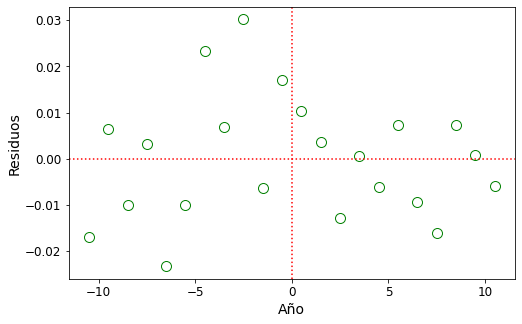

In [34]:
res = t.flatten() - y

# Plot residuals against feature $x_1$.
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)
ax.plot(X[:, 1], res, 'ok', mfc='None', ms=10, color='g')

ax.axhline(0, color='r', ls=':')
# ax.set_xlabel('Predicción / y')
ax.set_xlabel('Año')
ax.set_ylabel('Residuos')

# Add mean on each axis
xmean = X[:, 1].mean()
ax.axvline(xmean, color='r', ls=':')

Las ecuaciones normales nos garantizaban dos propiedades de los residuos:

$$
\sum_{i=1}^N r_i = 0
$$

$$
\rho(\mathbf{x}, \mathbf{r}) = 0
$$

In [ ]:
print('Suma de los residuos {:.16f}'.format(res.sum()))
print('$rho(X, res)$ = {:.16f}'.format(np.corrcoef(X[:, 1].T, res.T)[0, 1]))

De lo que dijimos arriba, se puede desprender, de manera informal, que $\mathbb{E}(r_i) = 0$, para todo $i = 1, \ldots, N$.

### Varianza de los residuos

Además, es interesante ver qué expresión tiene la variaza de los residuos:

$$\mathrm{var}(r_i) = \sigma^2 (1 - h_{ii})\;\;\text{, donde}$$

$$h_{ii} = \frac{1}{N} + \frac{X_i - \bar{X}}{S_{xx}}\text{ es el leverage}$$

De la definición de *leverage* podemos ver que los valores están acotados, de manera que nunca valen más que uno (de manera que la varianza nunca puede ser negativa).

Lo que resulta interesante es que una observación que tenga mucho leverage tendrá un residuo cuya varianza es muy inferior al valor de la varianza de su término de error. Esta observación tira del modelo para acercarlo a ella, por lo que genera esa reducción de la varianza.

Para ver esto, nada como datos sintéticos.

In [ ]:
# defino funciones útiles
def make_default_dataset(real_process, sigma=0.5, high_leverage=None, random_seed=20210331):
    # Fijo seed
    np.random.seed(random_seed)

    # Defino vector de x
    x = np.random.rand(20)

    # Por si quiero otra nube de puntos
#     x2 = np.random.rand(4) + 2.5
#     x = np.concatenate([x, x2])
        
    x = np.sort(x)

    # Agrego un punto con mucha palanca
    if high_leverage is not None:
        high_leverage_x = np.array(high_leverage)
        x = np.append(x, high_leverage_x)
    
    x_plot = np.linspace(x.min(), x.max(), 100).reshape(-1, 1)

    # Error
    t = real_process(x) + np.random.randn(len(x)) * sigma
    
    return x, t, x_plot

In [ ]:
def ground_truth(x):
    return 3*x + 4 #+ 0.1*x**2

# Creo los datos
x, t, x_plot = make_default_dataset(ground_truth, high_leverage=3.0)

# Plot datos y gt
plt.figure(figsize=(9, 6))
plt.plot(x, t, 'o', ms=10)
plt.plot(x_plot, ground_truth(x_plot), '-', color='0.5', label='Proceso real')
plt.xlabel('X', fontsize=16)
plt.ylabel('t', fontsize=16)

# Ajusto y ploteo ajuste
lr = LinearRegression()
lr.fit(x.reshape(-1, 1), t)
plt.plot(x_plot, lr.predict(x_plot), '-r', lw=4, alpha=0.5, label='Ajuste')
plt.legend(loc=0, fontsize=16)

# Calculo los residuos
res = t - lr.predict(x.reshape(-1, 1))

In [ ]:
print(lr.intercept_, lr.coef_)

Ahora repitamos el proceso de generación de datos (dejando fijas las variables $X$) y calculemos el mejor ajuste y los residuos. 

In [ ]:
nsimu=1000

res_ = np.empty((nsimu, len(x)))
t_ = np.empty((nsimu, len(x)))
sigma = 0.5
for i in range(nsimu):
    # Nuevo dataset
    t_new = ground_truth(x) + np.random.randn(len(x)) * sigma
    
    t_[i] = t_new
    # Ajusta y predice
    lr.fit(x.reshape(-1, 1), t_new)
    y = lr.predict(x.reshape(-1, 1))
    
    # Calcula residuos y guarda
    res_[i] = t_new - y
    
# Ordenemos los residuos por valor de x
res_ = res_[:, np.argsort(x)]
x_ = np.sort(x)

In [ ]:
# Plot datos y gt
plt.figure(figsize=(9, 6))
plt.plot(x, t, 'o', ms=10)
plt.plot(x, t_new, 'o', ms=10)
plt.plot(x_plot, ground_truth(x_plot), '-', color='0.5', label='Proceso real')
plt.xlabel('X', fontsize=16)
plt.ylabel('t', fontsize=16)

# Ajusto y ploteo ajuste
# lr = LinearRegression()
# lr.fit(x.reshape(-1, 1), t)
# plt.plot(x_plot, lr.predict(x_plot), '-r', lw=4, alpha=0.5, label='Ajuste')
# plt.legend(loc=0, fontsize=16)

# Calculo los residuos
# res = t - lr.predict(x.reshape(-1, 1))

Ahora hagamos histogramas de los residuos para distintos valores de $X$. Recordemos que, como nosotros definimos el proceso real, sabemos con certeza que $\sigma^2 = (0.5)^2$.

In [ ]:
# Veamos la dispersión de los datos entorno de la media del valor real
np.std(t_ - ground_truth(x), axis=0)

In [ ]:
indices_to_plot = [0, 11, -1]

plt.figure(figsize=(9, 6))
for i in indices_to_plot:
    plt.hist(res_[:, i], 25, label='X = {:.1f} (std(res) = {:.2f})'.format(x_[i], res_[:, i].std()), histtype='step', lw=3)
plt.xlabel('Residuals of observation X')
plt.legend(loc=0, fontsize=12)

### *Leverage* vs. Residuals

Un plot muy relevante es el de los valores de *leverage* en función de los residuos.

Sigamos por ahora con nuestros datos sintéticos.

In [39]:
# Calculamos leverage para los datos sintéticos
h = np.diag(hat_matrix(X))

Text(0.5, 0, 'Leverage')

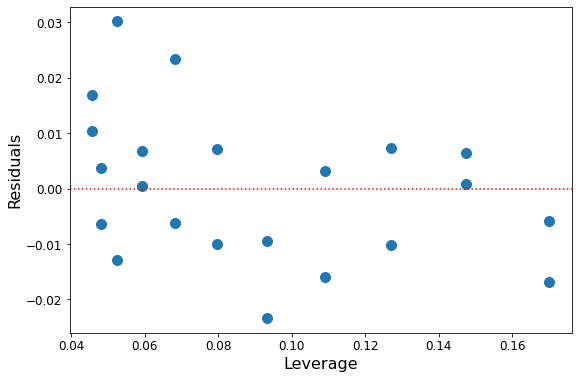

In [40]:
plt.figure(figsize=(9, 6))
plt.plot(h, res, 'o', ms=10)
plt.axhline(0, color='r', ls=':')
# plt.gca().set_xscale('log')

plt.ylabel('Residuals', fontsize=16)
plt.xlabel('Leverage', fontsize=16)

Otra forma de ver los *leverages* es con un boxplot

In [ ]:
fig = plt.figure(figsize=(9, 6))

ax = fig.add_subplot(121)
bp = ax.boxplot(h)
ax2 = fig.add_subplot(122)
hp = ax2.hist(h, histtype='step', color='k', lw=3)

### Residuos estandarizados

Una pequeña precisión que puede hacerse es definir los residuos estandarizados, en los que dividimos a cada residuo por la raíz cuadrada de varianza esperada.

$$
R_i = \frac{r_i}{\sqrt{\widehat{\mathrm{var}}(r_i)}} = \frac{r_i}{\sqrt{\widehat{\sigma}^2 (1 - h_{ii})}}
$$

In [ ]:
sigma2hat = np.sum(res**2)/(len(res) - 2)
stres = res / np.sqrt(sigma2hat * (1 - h))

Los plots que mencionamos arriba pueden volver a hacerse con los resiudos estandarizados.

In [ ]:
plt.figure(figsize=(9, 6))
plt.semilogx(h, stres, 'o', ms=10)
plt.axhline(0, color='r', ls=':')
# plt.gca().set_xscale('log')

plt.ylabel('Residuos Estandarizados', fontsize=16)
plt.xlabel('Leverage', fontsize=16)

## Outliers

Uno de los tests importantes a hacer es el de puntos atípicos (*outliers*). Si por alguna razón los datos tienen algún valor que no proviene del proceso real, eso puede modificar  el resultado del ajuste y, en particular, sesgarlo fuertemente.

Por ejemplo, agarremos los datos sintéticos y hagamos que uno de los puntos se vuelva un outlier, poniendo un valor a mano. Para que el efecto sea claro, tenemos que hacerlo en un punto que tenga palanca. Veamos...

In [43]:
def ground_truth(x):
    return 3*x + 4 #+ 0.1*x**2

# Function to make random dataset base on graound truth
def make_default_dataset(real_process, sigma=0.5, high_leverage=None, random_seed=20210331):
    # Fijo seed
    np.random.seed(random_seed)

    # Defino vector de x
    x = np.random.rand(20)

    # Por si quiero otra nube de puntos
#     x2 = np.random.rand(4) + 2.5
#     x = np.concatenate([x, x2])
        
    x = np.sort(x)

    # Agrego un punto con mucha palanca
    if high_leverage is not None:
        high_leverage_x = np.array(high_leverage)
        x = np.append(x, high_leverage_x)
    
    x_plot = np.linspace(x.min(), x.max(), 100).reshape(-1, 1)

    # Error
    t = real_process(x) + np.random.randn(len(x)) * sigma
    
    return x, t, x_plot

x, t, x_plot = make_default_dataset(ground_truth, high_leverage=3)

# Recompute leverage
h = np.diag(hat_matrix(x.reshape(-1, 1)))

# Define an outlier observation.
t[-1] = 10

In [44]:

x, t, x_plot = make_default_dataset(ground_truth, high_leverage=3.0)

# Recompute leverage
h = np.diag(hat_matrix(x.reshape(-1, 1)))

# Define an outlier observation.
t[-1] =10

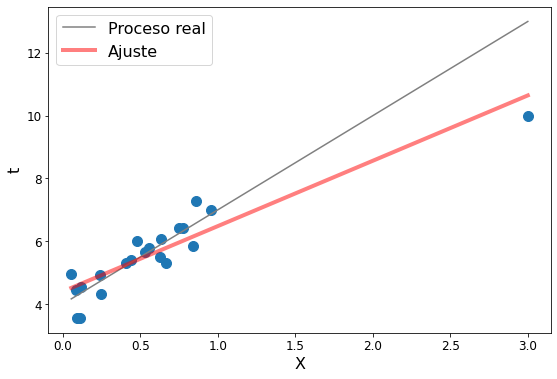

In [45]:
# Plot datos y gt
plt.figure(figsize=(9, 6))
plt.plot(x, t, 'o', ms=10)
plt.plot(x_plot, ground_truth(x_plot), '-', color='0.5', label='Proceso real')
plt.xlabel('X', fontsize=16)
plt.ylabel('t', fontsize=16)

# Ajusto y ploteo ajuste
lr = LinearRegression()
lr.fit(x.reshape(-1, 1), t)
plt.plot(x_plot, lr.predict(x_plot), '-r', lw=4, alpha=0.5, label='Ajuste')
plt.legend(loc=0, fontsize=16)

# Calculo los residuos
res = t - lr.predict(x.reshape(-1, 1))

Sin embargo, miren qué pasa si miramos el gráfico de leverage

Text(0.5, 0, 'Leverage')

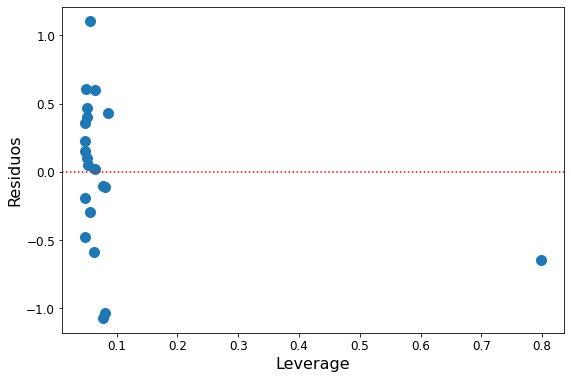

In [46]:
plt.figure(figsize=(9, 6))
plt.plot(h, res, 'o', ms=10)
plt.axhline(0, color='r', ls=':')
# plt.gca().set_xscale('log')

plt.ylabel('Residuos', fontsize=16)
plt.xlabel('Leverage', fontsize=16)

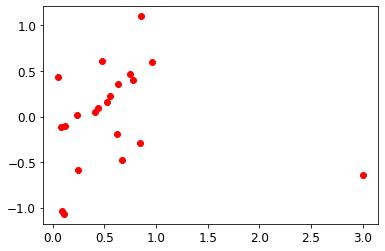

In [47]:
plt.plot(x, res, 'or')

Si bien el outlier está bastante afuera, no llama mucho la atención. Es claro lo que pasa: el outlier ya arrastró la solución y entonces el residuo es relativamente pequeño para ese punto.

**¿Y entonces? ¿Cómo hacemos? ¿Ideas? ¿Ideas que funcionen en muchas dimensiones?**

### Validación Cruzada

Una posibilidad, es hacer uso de una herramienta que será central en la materia para detectar y evitar el sobre-ajuste (*overfitting*), que se llama validación cruzada (*cross-validation*). 

Acá la vamos a usar para detectar el punto que se escapa. De alguna forma, también se trata de sobreajuste, porque el modelo intenta agarrar todo el set de entrenamiento, en lugar de preocuparse por reproducir la tendencia general, acá dada por el proceso real (¡que por suerte acá conocemos!).

La idea va a ser construir sub-sets de datos, a partir del set original, sacando un punto por vez. Es decir, se construyen $N$ conjuntos de $N-1$ datos, y se ajusta un modelo para cada uno de esos datos nuevos. Después, se compara la predicción que hace cada modelo para el punto que sacamos con la que hace el modelo ajustado a todos los datos.

La intuición es que cuando saquemos el outlier que está infuyendo en el ajuste, la predicción cambiará rotundamente.

Esto se llama *Leave-one-out cross-validation*, porque los puntos se van tomando de a uno. Hay muchos más sabores de validación cruzada, algunos de los cuales veremos más adelante.

In [48]:
# Implementación de LOOCV en sklearn
from sklearn.model_selection import LeaveOneOut, LeavePOut, cross_val_predict

loo = LeaveOneOut()
# loo = LeavePOut(3)
for train, test in loo.split(x):
    print(train, test)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] [0]
[ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] [1]
[ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] [2]
[ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] [3]
[ 0  1  2  3  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] [4]
[ 0  1  2  3  4  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] [5]
[ 0  1  2  3  4  5  7  8  9 10 11 12 13 14 15 16 17 18 19 20] [6]
[ 0  1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20] [7]
[ 0  1  2  3  4  5  6  7  9 10 11 12 13 14 15 16 17 18 19 20] [8]
[ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20] [9]
[ 0  1  2  3  4  5  6  7  8  9 11 12 13 14 15 16 17 18 19 20] [10]
[ 0  1  2  3  4  5  6  7  8  9 10 12 13 14 15 16 17 18 19 20] [11]
[ 0  1  2  3  4  5  6  7  8  9 10 11 13 14 15 16 17 18 19 20] [12]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 14 15 16 17 18 19 20] [13]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20] [14]
[ 0  

In [49]:
# Compute the predictions of Linear Regressor leaving each point out
y_iout = cross_val_predict(lr, x.reshape(-1, 1), t, cv=loo)

In [50]:
print(y_iout.shape, x.shape)

(21,) (21,)


In [51]:
# pero para entenderlo, está bueno hacerlo a mnos, aunque sea una vez.
y_iout_mano = np.empty_like(t)

for i, [train, test] in enumerate(loo.split(x)):
    x_i = x[train]
    t_i = t[train]
    
    lr.fit(x_i.reshape(-1, 1), t_i)
    y_ii = lr.predict(x[test].reshape(-1, 1))
    
    y_iout_mano[i] = y_ii

In [52]:
np.allclose(y_iout, y_iout_mano)

True

Text(0, 0.5, '$Y_i - Y_{i(i)}$')

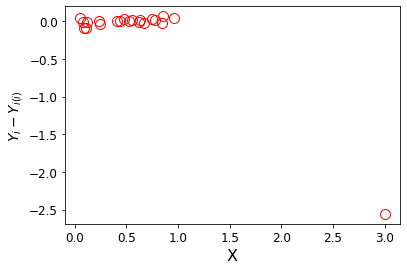

In [53]:
lr.fit(x.reshape(-1, 1), t)
y = lr.predict(x.reshape(-1, 1))
plt.plot(x, (y - y_iout), 'or', ms=10, mfc='None')
plt.xlabel('X', fontsize=16)
plt.ylabel('$Y_i - Y_{i(i)}$')

Podemos ver que claramente el outlier salta a la vista.

Para casos menos obvios, podemos definir un estadístico que se compara con alguna distribución razonable, pero no vamos a entrar en esos detalles ahora.

### Relevancia de una observación

Obviamente, un outlier como el que vimos recién es una observación muy influyente, que determina fuertemente el resultado del ajuste.

Pero si ese mismo outlier hubiera tenido menos palanca, la cosa hubiera sido diferente.

#### Ejercicio

* Modifiquen la posición y el valor del outlier. Vean qué influencia tiene en cada caso.
* Discutan qué combinación tiene que darse para que una medición sea influyente.
***

# Comparación de modelos

## Analysis of Variace (ANOVA)


El análisis de varianza (o ANOVA) está basado en el hecho de que la siguiente expresión es válida en general para $y$ obtenido a partir modelos de cuadrados mínimos:

$$
\underbrace{\sum_{i=1}^N\left(t - \bar{t}\right)^2}_{SC_\mathrm{tot}} = \underbrace{\sum_{i=1}^N\left(t - y\right)^2}_{SC_\mathrm{res}} + \underbrace{\sum_{i=1}^N\left(y - \bar{t}\right)^2}_{SC_\mathrm{reg}}\;\;,
$$

donde

$$
\bar{t} = \frac{1}{N}\sum_{j=1}^N t_j\;\;,
$$

puede pensarse como la predicción del modelo más simple que existe: ¡una constante!

**Nota**: siempre es muy importante tener un modelo de referencia con el que podamos comparar nuestro modelo. En el caso del modelo lineal simple, a menudo se usa el modelo constante aún más simple.

Podemos construir un estadístico que, intuitivamente, debería aumentar a medida que aumenta la capacidad del modelo para describir los datos:

$$
F\text{-statistic} = \frac{SC_\mathrm{reg}}{SC_\mathrm{res}/(N-2)}
$$

Se puede demostrar que, bajo la hipótesis de que el modelo es incorrecto (es decir, que ambos modelos explican bien los datos de manera equivalente), $ F\text{-statistic}$ sigue una distribución conocida (la distribución F, con 1, y $N -2$ grados de libertad). Grafiquemos esa distribución para nuestro valor de $N$

Text(0.5, 0, 'F-statistic')

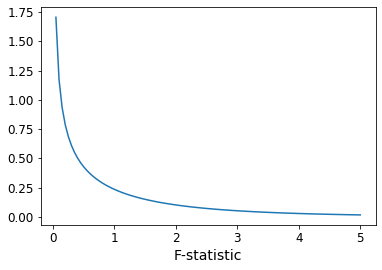

In [54]:
import scipy.stats as st

my_f = st.f(dfn=1, dfd=len(t)-2)

xx = np.linspace(0, 5, 100)
plt.plot(xx, my_f.pdf(xx))
plt.xlabel('F-statistic')

Ahora, si el valor de $ F \text{-statistic}$ es muy grande, entonces se puede rechazar la idea de que ambos modelos explican los datos de manera equivalente.

### Ejemplo con Airlines fatalities

**Base model**

In [55]:
year, acc, deaths, rate = np.loadtxt(os.path.join(AIRLINE_PATH, 'Data-Table 1.csv'), delimiter=',', skiprows=2, unpack=True)

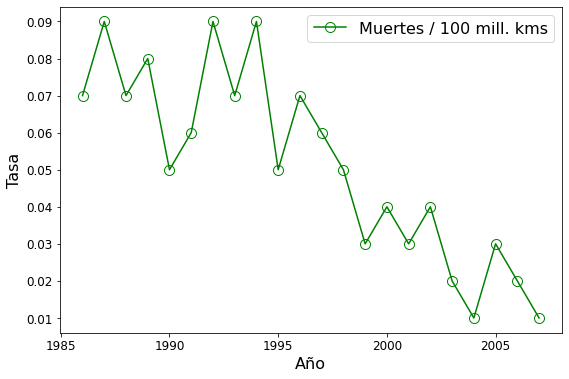

In [56]:
fig= plt.figure(figsize=(9, 6))

ax = fig.add_subplot(111)

l0, = ax.plot(year, rate, 'o-', mfc='None', ms=10, mew=1, color='g', label='Muertes / 100 mill. kms')

ax.set_xlabel('Año', fontsize=16)
ax.set_ylabel('Tasa', fontsize=16)

ax.legend(loc=0, fontsize=16)

In [57]:
# Le damos forma a los datos para prepararlos para statsmodels
X = year.reshape(-1, 1) - year.mean()
t = rate.reshape(-1, 1)

# Add intercept term
X = sm.tools.add_constant(X)

# Ajusta el modelo
results = sm.OLS(t, X).fit()

# Print results
print(results.summary())

# Compute the predictions
y = results.fittedvalues

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.731
Model:                            OLS   Adj. R-squared:                  0.717
Method:                 Least Squares   F-statistic:                     54.33
Date:                Thu, 02 Dec 2021   Prob (F-statistic):           4.04e-07
Time:                        15:09:10   Log-Likelihood:                 64.292
No. Observations:                  22   AIC:                            -124.6
Df Residuals:                      20   BIC:                            -122.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0514      0.003     17.643      0.0

In [58]:
anova(t.flatten(), t.flatten().mean(), [y,], 1, [2,])

Model     	dof	diferencia          	dof	F-stat	p-value
-----     	---	----------          	---	------	-------
Base      	N-1
New_1     	N-2	New_1 - Base        	1 	54.3276	4.04e-07


**Degree-two polynomial**

In [60]:
# Le damos forma a los datos para prepararlos para statsmodels
X = year.reshape(-1, 1) - year.mean()
t = rate.reshape(-1, 1)

# Add intercept term and degree two
X = np.vander(X.flatten(), 3, increasing=True)
print(X[:])
      
# Ajusta el modelo
results = sm.OLS(t, X).fit()

# Print results
print(results.summary())

# Compute the predictions
y2 = results.fittedvalues

[[  1.   -10.5  110.25]
 [  1.    -9.5   90.25]
 [  1.    -8.5   72.25]
 [  1.    -7.5   56.25]
 [  1.    -6.5   42.25]
 [  1.    -5.5   30.25]
 [  1.    -4.5   20.25]
 [  1.    -3.5   12.25]
 [  1.    -2.5    6.25]
 [  1.    -1.5    2.25]
 [  1.    -0.5    0.25]
 [  1.     0.5    0.25]
 [  1.     1.5    2.25]
 [  1.     2.5    6.25]
 [  1.     3.5   12.25]
 [  1.     4.5   20.25]
 [  1.     5.5   30.25]
 [  1.     6.5   42.25]
 [  1.     7.5   56.25]
 [  1.     8.5   72.25]
 [  1.     9.5   90.25]
 [  1.    10.5  110.25]]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.765
Model:                            OLS   Adj. R-squared:                  0.741
Method:                 Least Squares   F-statistic:                     31.00
Date:                Thu, 02 Dec 2021   Prob (F-statistic):           1.04e-06
Time:                        15:10:39   Log-Likelihood:                 65.8

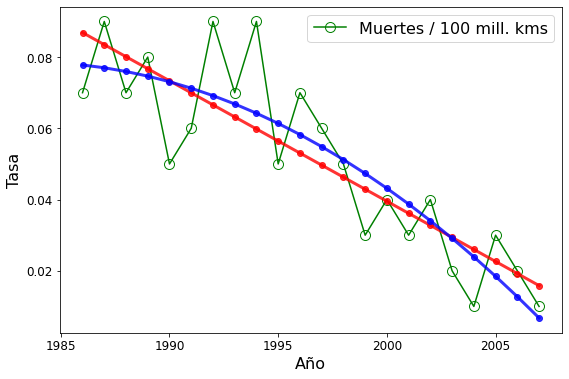

In [61]:
fig= plt.figure(figsize=(9, 6))

ax = fig.add_subplot(111)

l0, = ax.plot(year, rate, 'o-', mfc='None', ms=10, mew=1, color='g', label='Muertes / 100 mill. kms')
l1, = ax.plot(year, y, 'o-r', lw=3, alpha=0.8)
l2, = ax.plot(year, y2, 'o-b', lw=3, alpha=0.8)
ax.set_xlabel('Año', fontsize=16)
ax.set_ylabel('Tasa', fontsize=16)

ax.legend(loc=0, fontsize=16)

In [62]:
anova(t.flatten(), t.flatten().mean(), [y2,], 1, [3,])

Model     	dof	diferencia          	dof	F-stat	p-value
-----     	---	----------          	---	------	-------
Base      	N-1
New_1     	N-3	New_1 - Base        	2 	30.9954	1.04e-06


**¿Qué piensan que vamos a obtener del ANOVA en este caso?**

Hagámoslo. Pero ahora el modelo de base es el modelo lineal simple, así que la distribución con la que hay que comparar es nuevamente una $F_{1, N-3}$ (porque la diferencia entre ambos modelos es un solo grado de libertad.

In [63]:
anova(t.flatten(), y, [y2,], 2, [3,])

Model     	dof	diferencia          	dof	F-stat	p-value
-----     	---	----------          	---	------	-------
Base      	N-2
New_1     	N-3	New_1 - Base        	1 	2.7929	1.11e-01


**Conclusión**. En este caso, no podemos decir que sea preferible el modelo con un polinomio sobre el modelo lineal simple.

## Coeficiente de determinación

Un concepto relacionado es el coeficiente de determinación

$$
R^2 = \frac{SC_\mathrm{tot} - SC_\mathrm{res}}{SC_\mathrm{tot}}\;\;,
$$

que toma valores entre 0 y 1, y de alguna manera refleja qué parte de la varianza de los datos es explicada por el modelo. Existe una implementación de esto en `sklearn`.

In [64]:
from sklearn.metrics import r2_score
print('R^2 (lineal) = {:.3f}'.format(r2_score(t, y)))
print('R^2 (quadratic) = {:.3f}'.format(r2_score(t, y2)))

R^2 (lineal) = 0.731
R^2 (quadratic) = 0.765


Esto significa que alrededor del 73% de la varianza desaparece con el modelo lineal simple y un 76% con el modelo lineal múltiple.

# Su turno!

Les proponemos que exploren el dataset de alumnos.

In [ ]:
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/IAI-UNSAM/datasets/master/students/student-mat.csv')

In [ ]:
df.info()

Una descripción de cada columna puede encontrarse en la [página de Kaggle](https://www.kaggle.com/uciml/student-alcohol-consumption) de la que sacamos estos datos. 

* Les proponemos jugar a predecir el valor del examen final ($G3$) en base a cualquiera de lo o los features que tienen a disposición.
* Elijan criteriosamente un primer feature y después vayan agregando variables a medida que los datos lo requiran. Para esto último, usen el ANOVA.
* Evaluen el modelo mirando los residuos y haciendo plots equivalentes a los que usamos durante este notebook.

**Nota**: les dejamos una mini función para hacer 

In [ ]:
if 'google.colab' in sys.modules:

    def anova(t, y_base, y_model, nparam_base, nparam_models):
        """
        Perform simple ANOVA analysis.

        :param np.array t: label array (dimensions (nsamples, 1) or (nsamples,))
        :param np.array y_base: predictions from base model (dimensions (nsamples, 1) or (nsamples,))
        :param np.array y_model: predictions from new (more complex) models (dimensions (nmodels, nsamples)
        :param int nparam_base: number of parameters of base model
        :param list nparam_models: list with number of parameters of new models
        """
        y_model = np.atleast_2d(y_model)

        print('Model\tdof \tdiferencia \tdof \tF-stat\t p-value')
        print('-----\t--- \t---------- \t--- \t------\t -------')
        print('Base \tN-{:d}'.format(nparam_base))

        for i, [y, npar] in enumerate(zip(y_model, nparam_models)):
            # Compute squared sums
            screg = np.sum((y - y_base)**2) / (npar - nparam_base)
            scres = np.sum((t - y)**2) / ( len(t) - npar )

            fratio = screg/scres

            # Define appropiate F distribution
            my_f = st.f(dfn=(npar - nparam_base), dfd=(len(t) - npar))
            pvalue = 1 - my_f.cdf(fratio)

            printdict = {'model': i+1,
                         'npar': npar,
                         'dpar': npar - nparam_base,
                         'fratio': fratio,
                         'pvalue': pvalue
                         }
            # Print line in table
            print('New_{model:d} \tN-{npar:d} \tNew_{model:d} - Base \t{dpar:d} '
                  '\t{fratio:.4f}\t{pvalue:.2e}'.format(**printdict))            
        return
    
else:
    from utils import anova

In [ ]:
anova(t, y1, y2, 2, [3,])

**¡Funciona también para muchos modelos!**

In [ ]:
pp = PolynomialFeatures(degree=5)
xp5 = pp.fit_transform(x.reshape(-1, 1))
lr.fit(xp5, t)
y5 = lr.predict(xp5)

In [ ]:
xp5.shape

In [ ]:
anova(t, y1, [y2, y5], 2, [3, 6])